# Explore and clean text

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# NLTK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neperiana/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

print('train ->', train.shape)
print('test ->', test.shape)

train -> (7613, 5)
test -> (3263, 4)


In [13]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [34]:
train.target.describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

In [10]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Let's look at keywords

In [15]:
train['keyword'].value_counts( normalize=True)[:10]

fatalities     0.005959
deluge         0.005561
armageddon     0.005561
sinking        0.005429
damage         0.005429
harm           0.005429
body%20bags    0.005429
outbreak       0.005297
evacuate       0.005297
fear           0.005297
Name: keyword, dtype: float64

<AxesSubplot: xlabel='keyword'>

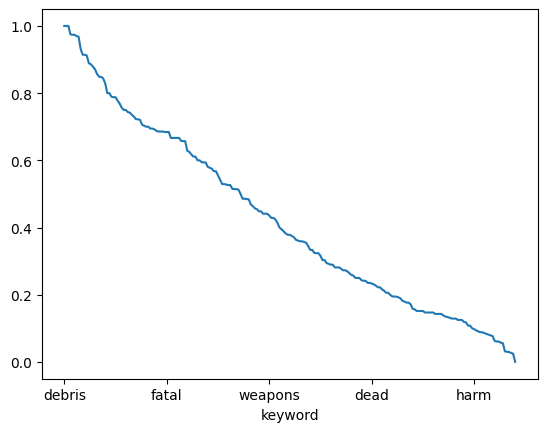

In [35]:
summary = train.groupby('keyword').agg(
    {'target': 'sum', 'keyword': 'count'}
).rename(
    columns={'target': 'disasters', 'keyword': 'base'}
)

summary['disaster_pct'] = summary['disasters'] / summary['base'] 

sorted_keywords = summary.sort_values(by='disaster_pct', ascending=False)['disaster_pct']

sorted_keywords.plot()

In [28]:
sorted_keywords[:25]

keyword
debris                   1.000000
wreckage                 1.000000
derailment               1.000000
outbreak                 0.975000
oil%20spill              0.973684
typhoon                  0.973684
suicide%20bombing        0.969697
suicide%20bomber         0.967742
bombing                  0.931034
rescuers                 0.914286
suicide%20bomb           0.914286
nuclear%20disaster       0.911765
evacuated                0.888889
razed                    0.885714
wildfire                 0.878788
wild%20fires             0.870968
airplane%20accident      0.857143
mass%20murder            0.848485
buildings%20on%20fire    0.848485
forest%20fires           0.843750
bridge%20collapse        0.828571
casualties               0.800000
drought                  0.800000
forest%20fire            0.789474
violent%20storm          0.787879
Name: disaster_pct, dtype: float64

And at location.

<AxesSubplot: >

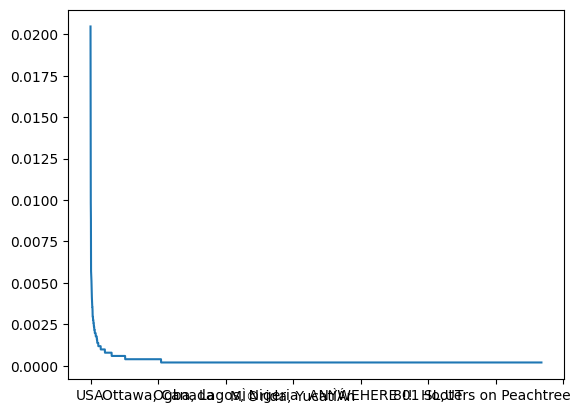

In [30]:
train['location'].value_counts(normalize=True).plot()

Let's quickly submit a base model based only in keywords.

In [46]:
summary['target'] = np.where(summary['disaster_pct'] > .5, 1, 0)
keyword_mapping = summary['target'].to_dict()

In [54]:
test['target'] = test['keyword'].map(keyword_mapping)
test['target'].fillna(0, inplace=True)
test['target'] = test['target'].astype(int)
test['target'].describe()

count    3263.000000
mean        0.376034
std         0.484463
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [55]:
submission_set = test[['id', 'target']]

In [56]:
submission_set.to_csv('../data/submissions/01-base-keyword-model.csv', index=False)

In [58]:
!kaggle competitions submit -c nlp-getting-started -f ../data/submissions/01-base-keyword-model.csv -m "base keyword model"

100%|██████████████████████████████████████| 22.2k/22.2k [00:01<00:00, 16.7kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets